In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 22 09:43:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   32C    P8    23W / 250W |   6751MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0    96W / 250W |   7736MiB / 16280MiB |     86%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca as Model
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_B as Model_B
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_F as Model_F
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_G as Model_G
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_H as Model_H

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 20)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 17.9 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 17.1 s
Constructing 160000 event dataset took 5.749 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 4.028 s
Constructing 9984 event dataset took 0.1547 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = Model_G()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/a380eb6159f74ca4b41964e7119d6570/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 6.0 parameter layers to update in the current model, 6.0 were loaded


In [10]:
model.to(device)

SimpleCNN5Layer_Ca_G(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 12, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(12, 8, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(8, 6, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(6, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


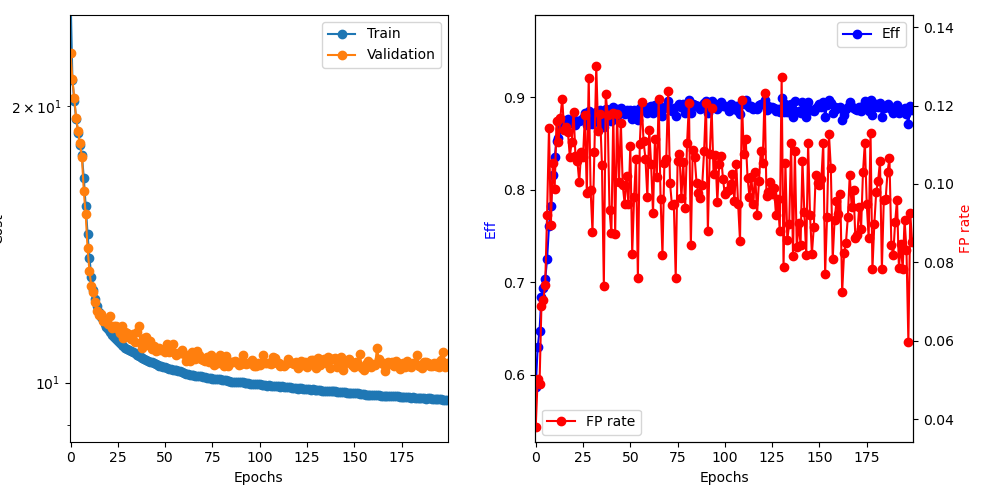

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  SimpleCNN5Layer_Ca_G(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 12, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(12, 8, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(8, 6, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(6, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)
epoch_start 20
batch_size 128
epochs 200
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 20: train=26.4851, val=22.8685, took 37.967 s
  Validation Found 31961 of 54504, added 380 (eff 58.64%) (0.0381 FP/event)


Epoch 21: train=21.3461, val=21.3985, took 38.158 s
  Validation Found 34317 of 54504, added 501 (eff 62.96%) (0.0502 FP/event)


Epoch 22: train=20.2636, val=20.4058, took 36.99 s
  Validation Found 35284 of 54504, added 489 (eff 64.74%) (0.049 FP/event)


Epoch 23: train=19.3557, val=19.4099, took 37.022 s
  Validation Found 37312 of 54504, added 687 (eff 68.46%) (0.0688 FP/event)


Epoch 24: train=18.7185, val=18.8028, took 36.647 s
  Validation Found 37804 of 54504, added 702 (eff 69.36%) (0.0703 FP/event)


Epoch 25: train=18.1722, val=18.2286, took 37.353 s
  Validation Found 38322 of 54504, added 742 (eff 70.31%) (0.0743 FP/event)


Epoch 26: train=17.6931, val=17.6345, took 37.866 s
  Validation Found 39531 of 54504, added 920 (eff 72.53%) (0.0921 FP/event)


Epoch 27: train=16.7142, val=16.1559, took 38.141 s
  Validation Found 41451 of 54504, added 1141 (eff 76.05%) (0.114 FP/event)


Epoch 28: train=15.5609, val=15.2628, took 37.868 s
  Validation Found 42661 of 54504, added 895 (eff 78.27%) (0.0896 FP/event)


Epoch 29: train=14.5305, val=14.0038, took 35.651 s
  Validation Found 44487 of 54504, added 1051 (eff 81.62%) (0.105 FP/event)


Epoch 30: train=13.6818, val=13.2213, took 30.771 s
  Validation Found 45500 of 54504, added 986 (eff 83.48%) (0.0987 FP/event)


Epoch 31: train=13.0471, val=12.7372, took 31.57 s
  Validation Found 46480 of 54504, added 1160 (eff 85.28%) (0.116 FP/event)


Epoch 32: train=12.6274, val=12.5403, took 31.935 s
  Validation Found 46623 of 54504, added 1105 (eff 85.54%) (0.111 FP/event)


Epoch 33: train=12.3342, val=12.2292, took 31.712 s
  Validation Found 47196 of 54504, added 1167 (eff 86.59%) (0.117 FP/event)


Epoch 34: train=12.1154, val=11.9701, took 31.502 s
  Validation Found 47626 of 54504, added 1216 (eff 87.38%) (0.122 FP/event)


Epoch 35: train=11.9419, val=11.8454, took 31.262 s
  Validation Found 47588 of 54504, added 1135 (eff 87.31%) (0.114 FP/event)


Epoch 36: train=11.7995, val=11.8745, took 30.756 s
  Validation Found 47641 of 54504, added 1144 (eff 87.41%) (0.115 FP/event)


Epoch 37: train=11.7012, val=11.6849, took 31.747 s
  Validation Found 47753 of 54504, added 1132 (eff 87.61%) (0.113 FP/event)


Epoch 38: train=11.5969, val=11.6705, took 30.955 s
  Validation Found 47527 of 54504, added 1068 (eff 87.20%) (0.107 FP/event)


Epoch 39: train=11.5119, val=11.6823, took 31.717 s
  Validation Found 47639 of 54504, added 1105 (eff 87.40%) (0.111 FP/event)


Epoch 40: train=11.4274, val=11.5944, took 31.432 s
  Validation Found 47730 of 54504, added 1183 (eff 87.57%) (0.118 FP/event)


Epoch 41: train=11.3524, val=11.824, took 31.329 s
  Validation Found 47388 of 54504, added 1069 (eff 86.94%) (0.107 FP/event)


Epoch 42: train=11.2828, val=11.4796, took 31.007 s
  Validation Found 47663 of 54504, added 1058 (eff 87.45%) (0.106 FP/event)


Epoch 43: train=11.216, val=11.5383, took 30.965 s
  Validation Found 47627 of 54504, added 1003 (eff 87.38%) (0.1 FP/event)


Epoch 44: train=11.1503, val=11.5221, took 31.44 s
  Validation Found 47722 of 54504, added 1081 (eff 87.56%) (0.108 FP/event)


Epoch 45: train=11.1052, val=11.4426, took 31.046 s
  Validation Found 47831 of 54504, added 1068 (eff 87.76%) (0.107 FP/event)


Epoch 46: train=11.0377, val=11.3195, took 31.248 s
  Validation Found 48103 of 54504, added 1174 (eff 88.26%) (0.118 FP/event)


Epoch 47: train=10.9987, val=11.532, took 31.362 s
  Validation Found 47385 of 54504, added 975 (eff 86.94%) (0.0976 FP/event)


Epoch 48: train=10.9598, val=11.1885, took 30.993 s
  Validation Found 48258 of 54504, added 1268 (eff 88.54%) (0.127 FP/event)


Epoch 49: train=10.9131, val=11.3429, took 30.881 s
  Validation Found 47611 of 54504, added 983 (eff 87.35%) (0.0984 FP/event)


Epoch 50: train=10.8889, val=11.3263, took 30.779 s
  Validation Found 47473 of 54504, added 877 (eff 87.10%) (0.0878 FP/event)


Epoch 51: train=10.8571, val=11.2099, took 30.992 s
  Validation Found 48006 of 54504, added 1079 (eff 88.08%) (0.108 FP/event)


Epoch 52: train=10.8216, val=11.1545, took 31.184 s
  Validation Found 48195 of 54504, added 1299 (eff 88.42%) (0.13 FP/event)


Epoch 53: train=10.7978, val=11.3088, took 30.79 s
  Validation Found 47805 of 54504, added 1133 (eff 87.71%) (0.113 FP/event)


Epoch 54: train=10.7589, val=11.0808, took 30.961 s
  Validation Found 48293 of 54504, added 1177 (eff 88.60%) (0.118 FP/event)


Epoch 55: train=10.7262, val=11.3666, took 31.148 s
  Validation Found 47639 of 54504, added 1048 (eff 87.40%) (0.105 FP/event)


Epoch 56: train=10.6978, val=11.5395, took 31.006 s
  Validation Found 47279 of 54504, added 739 (eff 86.74%) (0.074 FP/event)


Epoch 57: train=10.6683, val=11.049, took 30.727 s
  Validation Found 48344 of 54504, added 1227 (eff 88.70%) (0.123 FP/event)


Epoch 58: train=10.6332, val=10.8988, took 31.105 s
  Validation Found 48319 of 54504, added 1175 (eff 88.65%) (0.118 FP/event)


Epoch 59: train=10.6126, val=11.1743, took 31.237 s
  Validation Found 47852 of 54504, added 931 (eff 87.80%) (0.0932 FP/event)


Epoch 60: train=10.5833, val=11.2201, took 30.908 s
  Validation Found 47630 of 54504, added 873 (eff 87.39%) (0.0874 FP/event)


Epoch 61: train=10.5623, val=10.9803, took 31.083 s
  Validation Found 48482 of 54504, added 1180 (eff 88.95%) (0.118 FP/event)


Epoch 62: train=10.5402, val=11.1049, took 30.805 s
  Validation Found 47746 of 54504, added 871 (eff 87.60%) (0.0872 FP/event)


Epoch 63: train=10.5202, val=10.8846, took 30.83 s
  Validation Found 48357 of 54504, added 1177 (eff 88.72%) (0.118 FP/event)


Epoch 64: train=10.5021, val=10.9628, took 31.432 s
  Validation Found 48041 of 54504, added 1004 (eff 88.14%) (0.101 FP/event)


Epoch 65: train=10.4791, val=10.8127, took 30.976 s
  Validation Found 48393 of 54504, added 1154 (eff 88.79%) (0.116 FP/event)


Epoch 66: train=10.4587, val=10.8467, took 30.905 s
  Validation Found 48235 of 54504, added 995 (eff 88.50%) (0.0996 FP/event)


Epoch 67: train=10.4388, val=10.9016, took 30.774 s
  Validation Found 48063 of 54504, added 948 (eff 88.18%) (0.0949 FP/event)


Epoch 68: train=10.4223, val=10.8485, took 31.149 s
  Validation Found 48289 of 54504, added 1020 (eff 88.60%) (0.102 FP/event)


Epoch 69: train=10.405, val=10.864, took 30.788 s
  Validation Found 48092 of 54504, added 947 (eff 88.24%) (0.0948 FP/event)


Epoch 70: train=10.3898, val=10.7854, took 30.641 s
  Validation Found 48277 of 54504, added 1094 (eff 88.58%) (0.11 FP/event)


Epoch 71: train=10.3752, val=11.0193, took 30.766 s
  Validation Found 47773 of 54504, added 821 (eff 87.65%) (0.0822 FP/event)


Epoch 72: train=10.3492, val=10.7978, took 30.695 s
  Validation Found 48288 of 54504, added 965 (eff 88.60%) (0.0966 FP/event)


Epoch 73: train=10.3402, val=10.8592, took 30.726 s
  Validation Found 48201 of 54504, added 1063 (eff 88.44%) (0.106 FP/event)


Epoch 74: train=10.3328, val=11.0269, took 30.873 s
  Validation Found 47705 of 54504, added 759 (eff 87.53%) (0.076 FP/event)


Epoch 75: train=10.3226, val=10.78, took 30.722 s
  Validation Found 48404 of 54504, added 1100 (eff 88.81%) (0.11 FP/event)


Epoch 76: train=10.3211, val=10.7069, took 30.735 s
  Validation Found 48538 of 54504, added 1207 (eff 89.05%) (0.121 FP/event)


Epoch 77: train=10.3046, val=10.764, took 30.936 s
  Validation Found 48482 of 54504, added 1107 (eff 88.95%) (0.111 FP/event)


Epoch 78: train=10.2881, val=10.7658, took 30.908 s
  Validation Found 48315 of 54504, added 1063 (eff 88.64%) (0.106 FP/event)


Epoch 79: train=10.2692, val=10.8467, took 30.801 s
  Validation Found 48092 of 54504, added 966 (eff 88.24%) (0.0967 FP/event)


Epoch 80: train=10.251, val=10.733, took 30.854 s
  Validation Found 48460 of 54504, added 1136 (eff 88.91%) (0.114 FP/event)


Epoch 81: train=10.2294, val=10.5681, took 30.705 s
  Validation Found 48520 of 54504, added 1049 (eff 89.02%) (0.105 FP/event)


Epoch 82: train=10.2217, val=10.648, took 31.201 s
  Validation Found 48126 of 54504, added 924 (eff 88.30%) (0.0925 FP/event)


Epoch 83: train=10.2009, val=10.5527, took 30.628 s
  Validation Found 48604 of 54504, added 1112 (eff 89.18%) (0.111 FP/event)


Epoch 84: train=10.1996, val=10.8003, took 30.861 s
  Validation Found 48303 of 54504, added 1015 (eff 88.62%) (0.102 FP/event)


Epoch 85: train=10.182, val=10.7184, took 30.856 s
  Validation Found 48575 of 54504, added 1215 (eff 89.12%) (0.122 FP/event)


Epoch 86: train=10.1756, val=10.6055, took 30.879 s
  Validation Found 48323 of 54504, added 961 (eff 88.66%) (0.0962 FP/event)


Epoch 87: train=10.1673, val=10.8285, took 30.984 s
  Validation Found 47930 of 54504, added 818 (eff 87.94%) (0.0819 FP/event)


Epoch 88: train=10.1564, val=10.7149, took 30.84 s
  Validation Found 48434 of 54504, added 1051 (eff 88.86%) (0.105 FP/event)


Epoch 89: train=10.1557, val=10.6211, took 30.948 s
  Validation Found 48491 of 54504, added 1062 (eff 88.97%) (0.106 FP/event)


Epoch 90: train=10.1447, val=10.5875, took 30.689 s
  Validation Found 48825 of 54504, added 1235 (eff 89.58%) (0.124 FP/event)


Epoch 91: train=10.1411, val=10.563, took 30.7 s
  Validation Found 48380 of 54504, added 1000 (eff 88.76%) (0.1 FP/event)


Epoch 92: train=10.1228, val=10.6689, took 30.719 s
  Validation Found 48244 of 54504, added 945 (eff 88.51%) (0.0946 FP/event)


Epoch 93: train=10.1169, val=10.5189, took 31.067 s
  Validation Found 48423 of 54504, added 948 (eff 88.84%) (0.0949 FP/event)


Epoch 94: train=10.1045, val=10.7072, took 31.073 s
  Validation Found 47959 of 54504, added 760 (eff 87.99%) (0.0761 FP/event)


Epoch 95: train=10.1015, val=10.6658, took 30.779 s
  Validation Found 48521 of 54504, added 1058 (eff 89.02%) (0.106 FP/event)


Epoch 96: train=10.0966, val=10.4425, took 31.001 s
  Validation Found 48651 of 54504, added 1074 (eff 89.26%) (0.108 FP/event)


Epoch 97: train=10.0866, val=10.5287, took 31.031 s
  Validation Found 48484 of 54504, added 963 (eff 88.95%) (0.0964 FP/event)


Epoch 98: train=10.0821, val=10.5029, took 31.096 s
  Validation Found 48623 of 54504, added 1054 (eff 89.21%) (0.106 FP/event)


Epoch 99: train=10.0821, val=10.709, took 30.787 s
  Validation Found 48137 of 54504, added 938 (eff 88.32%) (0.0939 FP/event)


Epoch 100: train=10.0699, val=10.4935, took 30.843 s
  Validation Found 48572 of 54504, added 1102 (eff 89.12%) (0.11 FP/event)


Epoch 101: train=10.0603, val=10.4275, took 31.405 s
  Validation Found 48862 of 54504, added 1204 (eff 89.65%) (0.121 FP/event)


Epoch 102: train=10.0553, val=10.692, took 31.085 s
  Validation Found 48111 of 54504, added 843 (eff 88.27%) (0.0844 FP/event)


Epoch 103: train=10.0509, val=10.4381, took 30.803 s
  Validation Found 48631 of 54504, added 1086 (eff 89.22%) (0.109 FP/event)


Epoch 104: train=10.0357, val=10.526, took 30.781 s
  Validation Found 48596 of 54504, added 1068 (eff 89.16%) (0.107 FP/event)


Epoch 105: train=10.0253, val=10.5315, took 30.729 s
  Validation Found 48516 of 54504, added 1002 (eff 89.01%) (0.1 FP/event)


Epoch 106: train=10.0232, val=10.5336, took 30.886 s
  Validation Found 48503 of 54504, added 976 (eff 88.99%) (0.0977 FP/event)


Epoch 107: train=10.0211, val=10.5663, took 30.829 s
  Validation Found 48341 of 54504, added 962 (eff 88.69%) (0.0963 FP/event)


Epoch 108: train=10.0155, val=10.5317, took 30.722 s
  Validation Found 48455 of 54504, added 995 (eff 88.90%) (0.0996 FP/event)


Epoch 109: train=10.0182, val=10.443, took 31.096 s
  Validation Found 48711 of 54504, added 1082 (eff 89.37%) (0.108 FP/event)


Epoch 110: train=10.0085, val=10.4757, took 30.803 s
  Validation Found 48805 of 54504, added 1206 (eff 89.54%) (0.121 FP/event)


Epoch 111: train=10.0065, val=10.7096, took 30.757 s
  Validation Found 48133 of 54504, added 880 (eff 88.31%) (0.0881 FP/event)


Epoch 112: train=9.99429, val=10.4984, took 30.923 s
  Validation Found 48599 of 54504, added 1075 (eff 89.17%) (0.108 FP/event)


Epoch 113: train=9.98799, val=10.4698, took 30.778 s
  Validation Found 48830 of 54504, added 1192 (eff 89.59%) (0.119 FP/event)


Epoch 114: train=9.97953, val=10.5024, took 30.753 s
  Validation Found 48596 of 54504, added 1025 (eff 89.16%) (0.103 FP/event)


Epoch 115: train=9.96954, val=10.5036, took 31.151 s
  Validation Found 48640 of 54504, added 1073 (eff 89.24%) (0.107 FP/event)


Epoch 116: train=9.96696, val=10.5901, took 30.944 s
  Validation Found 48335 of 54504, added 953 (eff 88.68%) (0.0954 FP/event)


Epoch 117: train=9.96852, val=10.4226, took 30.762 s
  Validation Found 48621 of 54504, added 1050 (eff 89.21%) (0.105 FP/event)


Epoch 118: train=9.96425, val=10.4367, took 30.832 s
  Validation Found 48777 of 54504, added 1071 (eff 89.49%) (0.107 FP/event)


Epoch 119: train=9.96131, val=10.4924, took 30.776 s
  Validation Found 48541 of 54504, added 1010 (eff 89.06%) (0.101 FP/event)


Epoch 120: train=9.95579, val=10.4591, took 30.707 s
  Validation Found 48545 of 54504, added 972 (eff 89.07%) (0.0973 FP/event)


Epoch 121: train=9.93884, val=10.5049, took 31.069 s
  Validation Found 48462 of 54504, added 980 (eff 88.91%) (0.0981 FP/event)


Epoch 122: train=9.94461, val=10.7074, took 30.794 s
  Validation Found 48229 of 54504, added 983 (eff 88.49%) (0.0984 FP/event)


Epoch 123: train=9.93992, val=10.5173, took 30.721 s
  Validation Found 48644 of 54504, added 998 (eff 89.25%) (0.0999 FP/event)


Epoch 124: train=9.92743, val=10.5078, took 30.724 s
  Validation Found 48468 of 54504, added 1025 (eff 88.93%) (0.103 FP/event)


Epoch 125: train=9.93268, val=10.5112, took 30.712 s
  Validation Found 48343 of 54504, added 954 (eff 88.70%) (0.0955 FP/event)


Epoch 126: train=9.92468, val=10.4858, took 30.773 s
  Validation Found 48537 of 54504, added 1050 (eff 89.05%) (0.105 FP/event)


Epoch 127: train=9.92091, val=10.6672, took 30.864 s
  Validation Found 48264 of 54504, added 947 (eff 88.55%) (0.0948 FP/event)


Epoch 128: train=9.91807, val=10.6415, took 30.872 s
  Validation Found 48077 of 54504, added 853 (eff 88.21%) (0.0854 FP/event)


Epoch 129: train=9.90646, val=10.5112, took 30.773 s
  Validation Found 48788 of 54504, added 1212 (eff 89.51%) (0.121 FP/event)


Epoch 130: train=9.90742, val=10.5029, took 30.737 s
  Validation Found 48658 of 54504, added 1074 (eff 89.27%) (0.108 FP/event)


Epoch 131: train=9.90239, val=10.4199, took 30.9 s
  Validation Found 48860 of 54504, added 1113 (eff 89.64%) (0.111 FP/event)


Epoch 132: train=9.90402, val=10.4495, took 30.802 s
  Validation Found 48564 of 54504, added 1013 (eff 89.10%) (0.101 FP/event)


Epoch 133: train=9.89657, val=10.4177, took 31.603 s
  Validation Found 48469 of 54504, added 966 (eff 88.93%) (0.0967 FP/event)


Epoch 134: train=9.88638, val=10.4784, took 31.242 s
  Validation Found 48526 of 54504, added 1016 (eff 89.03%) (0.102 FP/event)


Epoch 135: train=9.89108, val=10.6173, took 31.152 s
  Validation Found 48333 of 54504, added 947 (eff 88.68%) (0.0948 FP/event)


Epoch 136: train=9.88653, val=10.5255, took 30.899 s
  Validation Found 48395 of 54504, added 1028 (eff 88.79%) (0.103 FP/event)


Epoch 137: train=9.86582, val=10.5157, took 31.445 s
  Validation Found 48364 of 54504, added 920 (eff 88.73%) (0.0921 FP/event)


Epoch 138: train=9.86737, val=10.4859, took 31.095 s
  Validation Found 48616 of 54504, added 1006 (eff 89.20%) (0.101 FP/event)


Epoch 139: train=9.85875, val=10.5217, took 31.152 s
  Validation Found 48636 of 54504, added 1083 (eff 89.23%) (0.108 FP/event)


Epoch 140: train=9.85276, val=10.379, took 31.105 s
  Validation Found 48664 of 54504, added 1053 (eff 89.29%) (0.105 FP/event)


Epoch 141: train=9.85709, val=10.5108, took 31.067 s
  Validation Found 48875 of 54504, added 1230 (eff 89.67%) (0.123 FP/event)


Epoch 142: train=9.85431, val=10.5557, took 30.977 s
  Validation Found 48274 of 54504, added 969 (eff 88.57%) (0.097 FP/event)


Epoch 143: train=9.83483, val=10.4393, took 30.817 s
  Validation Found 48505 of 54504, added 978 (eff 88.99%) (0.0979 FP/event)


Epoch 144: train=9.84131, val=10.5321, took 30.865 s
  Validation Found 48389 of 54504, added 1004 (eff 88.78%) (0.101 FP/event)


Epoch 145: train=9.83859, val=10.4107, took 30.864 s
  Validation Found 48485 of 54504, added 973 (eff 88.96%) (0.0974 FP/event)


Epoch 146: train=9.834, val=10.4766, took 30.767 s
  Validation Found 48399 of 54504, added 989 (eff 88.80%) (0.099 FP/event)


Epoch 147: train=9.82893, val=10.5949, took 31.276 s
  Validation Found 48208 of 54504, added 920 (eff 88.45%) (0.0921 FP/event)


Epoch 148: train=9.83242, val=10.584, took 30.758 s
  Validation Found 48348 of 54504, added 959 (eff 88.71%) (0.096 FP/event)


Epoch 149: train=9.82039, val=10.5613, took 30.759 s
  Validation Found 48195 of 54504, added 879 (eff 88.42%) (0.088 FP/event)


Epoch 150: train=9.82057, val=10.3797, took 30.834 s
  Validation Found 48989 of 54504, added 1271 (eff 89.88%) (0.127 FP/event)


Epoch 151: train=9.81149, val=10.6331, took 30.788 s
  Validation Found 48194 of 54504, added 787 (eff 88.42%) (0.0788 FP/event)


Epoch 152: train=9.80609, val=10.4402, took 30.781 s
  Validation Found 48639 of 54504, added 1051 (eff 89.24%) (0.105 FP/event)


Epoch 153: train=9.8029, val=10.5524, took 30.92 s
  Validation Found 48201 of 54504, added 856 (eff 88.44%) (0.0857 FP/event)


Epoch 154: train=9.80234, val=10.6073, took 30.943 s
  Validation Found 48190 of 54504, added 897 (eff 88.42%) (0.0898 FP/event)


Epoch 155: train=9.79242, val=10.4996, took 31.067 s
  Validation Found 48661 of 54504, added 1102 (eff 89.28%) (0.11 FP/event)


Epoch 156: train=9.79661, val=10.657, took 30.96 s
  Validation Found 47903 of 54504, added 815 (eff 87.89%) (0.0816 FP/event)


Epoch 157: train=9.78861, val=10.3642, took 30.8 s
  Validation Found 48850 of 54504, added 1083 (eff 89.63%) (0.108 FP/event)


Epoch 158: train=9.78012, val=10.6021, took 30.79 s
  Validation Found 48184 of 54504, added 837 (eff 88.40%) (0.0838 FP/event)


Epoch 159: train=9.78551, val=10.6187, took 31.169 s
  Validation Found 48222 of 54504, added 900 (eff 88.47%) (0.0901 FP/event)


Epoch 160: train=9.7932, val=10.6259, took 30.828 s
  Validation Found 48109 of 54504, added 844 (eff 88.27%) (0.0845 FP/event)


Epoch 161: train=9.77538, val=10.3946, took 31.596 s
  Validation Found 48739 of 54504, added 1057 (eff 89.42%) (0.106 FP/event)


Epoch 162: train=9.77037, val=10.5121, took 31.018 s
  Validation Found 48525 of 54504, added 926 (eff 89.03%) (0.0927 FP/event)


Epoch 163: train=9.76828, val=10.6588, took 30.848 s
  Validation Found 47885 of 54504, added 817 (eff 87.86%) (0.0818 FP/event)


Epoch 164: train=9.76355, val=10.3109, took 31.056 s
  Validation Found 48788 of 54504, added 1103 (eff 89.51%) (0.11 FP/event)


Epoch 165: train=9.76306, val=10.5085, took 30.939 s
  Validation Found 48301 of 54504, added 920 (eff 88.62%) (0.0921 FP/event)


Epoch 166: train=9.75099, val=10.5296, took 31.007 s
  Validation Found 48270 of 54504, added 821 (eff 88.56%) (0.0822 FP/event)


Epoch 167: train=9.74262, val=10.6094, took 30.934 s
  Validation Found 48231 of 54504, added 888 (eff 88.49%) (0.0889 FP/event)


Epoch 168: train=9.74528, val=10.5595, took 31.219 s
  Validation Found 48390 of 54504, added 1022 (eff 88.78%) (0.102 FP/event)


Epoch 169: train=9.73966, val=10.4525, took 30.845 s
  Validation Found 48503 of 54504, added 1002 (eff 88.99%) (0.1 FP/event)


Epoch 170: train=9.73939, val=10.3889, took 31.026 s
  Validation Found 48670 of 54504, added 996 (eff 89.30%) (0.0997 FP/event)


Epoch 171: train=9.74363, val=10.5237, took 30.871 s
  Validation Found 48458 of 54504, added 1010 (eff 88.91%) (0.101 FP/event)


Epoch 172: train=9.74046, val=10.4441, took 30.792 s
  Validation Found 48762 of 54504, added 1103 (eff 89.46%) (0.11 FP/event)


Epoch 173: train=9.72453, val=10.7439, took 30.922 s
  Validation Found 47862 of 54504, added 770 (eff 87.81%) (0.0771 FP/event)


Epoch 174: train=9.7182, val=10.3771, took 30.764 s
  Validation Found 48607 of 54504, added 914 (eff 89.18%) (0.0915 FP/event)


Epoch 175: train=9.71108, val=10.3131, took 30.96 s
  Validation Found 48901 of 54504, added 1127 (eff 89.72%) (0.113 FP/event)


Epoch 176: train=9.69427, val=10.482, took 30.849 s
  Validation Found 48730 of 54504, added 1040 (eff 89.41%) (0.104 FP/event)


Epoch 177: train=9.69926, val=10.5558, took 30.751 s
  Validation Found 48129 of 54504, added 808 (eff 88.30%) (0.0809 FP/event)


Epoch 178: train=9.69952, val=10.4715, took 30.879 s
  Validation Found 48455 of 54504, added 907 (eff 88.90%) (0.0908 FP/event)


Epoch 179: train=9.70127, val=10.4008, took 30.838 s
  Validation Found 48369 of 54504, added 955 (eff 88.74%) (0.0956 FP/event)


Epoch 180: train=9.69342, val=10.4754, took 30.727 s
  Validation Found 48404 of 54504, added 923 (eff 88.81%) (0.0924 FP/event)


Epoch 181: train=9.70074, val=10.4418, took 30.664 s
  Validation Found 48462 of 54504, added 972 (eff 88.91%) (0.0973 FP/event)


Epoch 182: train=9.69004, val=10.8996, took 30.936 s
  Validation Found 47688 of 54504, added 723 (eff 87.49%) (0.0724 FP/event)


Epoch 183: train=9.68527, val=10.6132, took 30.899 s
  Validation Found 48005 of 54504, added 822 (eff 88.08%) (0.0823 FP/event)


Epoch 184: train=9.68046, val=10.5214, took 31.106 s
  Validation Found 48358 of 54504, added 849 (eff 88.72%) (0.085 FP/event)


Epoch 185: train=9.67905, val=10.4884, took 30.691 s
  Validation Found 48448 of 54504, added 914 (eff 88.89%) (0.0915 FP/event)


Epoch 186: train=9.67824, val=10.2989, took 31.511 s
  Validation Found 48762 of 54504, added 1021 (eff 89.46%) (0.102 FP/event)


Epoch 187: train=9.67338, val=10.4331, took 31.275 s
  Validation Found 48499 of 54504, added 941 (eff 88.98%) (0.0942 FP/event)


Epoch 188: train=9.66912, val=10.5314, took 31.003 s
  Validation Found 48411 of 54504, added 982 (eff 88.82%) (0.0983 FP/event)


Epoch 189: train=9.66762, val=10.5026, took 30.877 s
  Validation Found 48346 of 54504, added 860 (eff 88.70%) (0.0861 FP/event)


Epoch 190: train=9.66293, val=10.5252, took 30.866 s
  Validation Found 48323 of 54504, added 869 (eff 88.66%) (0.087 FP/event)


Epoch 191: train=9.66082, val=10.4206, took 30.764 s
  Validation Found 48463 of 54504, added 940 (eff 88.92%) (0.0941 FP/event)


Epoch 192: train=9.65967, val=10.5636, took 30.787 s
  Validation Found 48265 of 54504, added 885 (eff 88.55%) (0.0886 FP/event)


Epoch 193: train=9.65999, val=10.4966, took 30.802 s
  Validation Found 48557 of 54504, added 1028 (eff 89.09%) (0.103 FP/event)


Epoch 194: train=9.64659, val=10.3503, took 31.117 s
  Validation Found 48842 of 54504, added 1104 (eff 89.61%) (0.111 FP/event)


Epoch 195: train=9.64901, val=10.4124, took 30.971 s
  Validation Found 48555 of 54504, added 947 (eff 89.09%) (0.0948 FP/event)


Epoch 196: train=9.65248, val=10.4961, took 31.16 s
  Validation Found 48227 of 54504, added 862 (eff 88.48%) (0.0863 FP/event)


Epoch 197: train=9.64671, val=10.3929, took 30.954 s
  Validation Found 48875 of 54504, added 1128 (eff 89.67%) (0.113 FP/event)


Epoch 198: train=9.64053, val=10.5543, took 31.233 s
  Validation Found 48014 of 54504, added 782 (eff 88.09%) (0.0783 FP/event)


Epoch 199: train=9.63599, val=10.4281, took 30.838 s
  Validation Found 48497 of 54504, added 896 (eff 88.98%) (0.0897 FP/event)


Epoch 200: train=9.62994, val=10.3914, took 31.541 s
  Validation Found 48670 of 54504, added 979 (eff 89.30%) (0.098 FP/event)


Epoch 201: train=9.64214, val=10.4975, took 30.886 s
  Validation Found 48455 of 54504, added 1006 (eff 88.90%) (0.101 FP/event)


Epoch 202: train=9.62112, val=10.4952, took 30.82 s
  Validation Found 48730 of 54504, added 1057 (eff 89.41%) (0.106 FP/event)


Epoch 203: train=9.62219, val=10.7072, took 30.87 s
  Validation Found 47887 of 54504, added 782 (eff 87.86%) (0.0783 FP/event)


Epoch 204: train=9.61363, val=10.4155, took 30.923 s
  Validation Found 48427 of 54504, added 957 (eff 88.85%) (0.0958 FP/event)


Epoch 205: train=9.6235, val=10.4619, took 31.074 s
  Validation Found 48450 of 54504, added 961 (eff 88.89%) (0.0962 FP/event)


Epoch 206: train=9.61935, val=10.3616, took 31.094 s
  Validation Found 48672 of 54504, added 1030 (eff 89.30%) (0.103 FP/event)


Epoch 207: train=9.62045, val=10.5369, took 31.054 s
  Validation Found 48473 of 54504, added 1064 (eff 88.93%) (0.107 FP/event)


Epoch 208: train=9.60779, val=10.5321, took 31.114 s
  Validation Found 48335 of 54504, added 844 (eff 88.68%) (0.0845 FP/event)


Epoch 209: train=9.60988, val=10.5175, took 30.996 s
  Validation Found 48131 of 54504, added 818 (eff 88.31%) (0.0819 FP/event)


Epoch 210: train=9.61903, val=10.4353, took 31.277 s
  Validation Found 48440 of 54504, added 901 (eff 88.87%) (0.0902 FP/event)


Epoch 211: train=9.59861, val=10.4262, took 31.106 s
  Validation Found 48575 of 54504, added 958 (eff 89.12%) (0.0959 FP/event)


Epoch 212: train=9.59655, val=10.494, took 31.012 s
  Validation Found 48109 of 54504, added 784 (eff 88.27%) (0.0785 FP/event)


Epoch 213: train=9.60361, val=10.4361, took 30.914 s
  Validation Found 48309 of 54504, added 845 (eff 88.63%) (0.0846 FP/event)


Epoch 214: train=9.59327, val=10.5086, took 31.092 s
  Validation Found 48209 of 54504, added 782 (eff 88.45%) (0.0783 FP/event)


Epoch 215: train=9.59174, val=10.3967, took 31.109 s
  Validation Found 48428 of 54504, added 907 (eff 88.85%) (0.0908 FP/event)


Epoch 216: train=9.58851, val=10.5945, took 31.002 s
  Validation Found 48050 of 54504, added 830 (eff 88.16%) (0.0831 FP/event)


Epoch 217: train=9.58082, val=10.7888, took 31.078 s
  Validation Found 47469 of 54504, added 597 (eff 87.09%) (0.0598 FP/event)


Epoch 218: train=9.58438, val=10.4034, took 31.887 s
  Validation Found 48546 of 54504, added 924 (eff 89.07%) (0.0925 FP/event)


Epoch 219: train=9.57978, val=10.4999, took 31.476 s
  Validation Found 48314 of 54504, added 850 (eff 88.64%) (0.0851 FP/event)



<IPython.core.display.Javascript object>


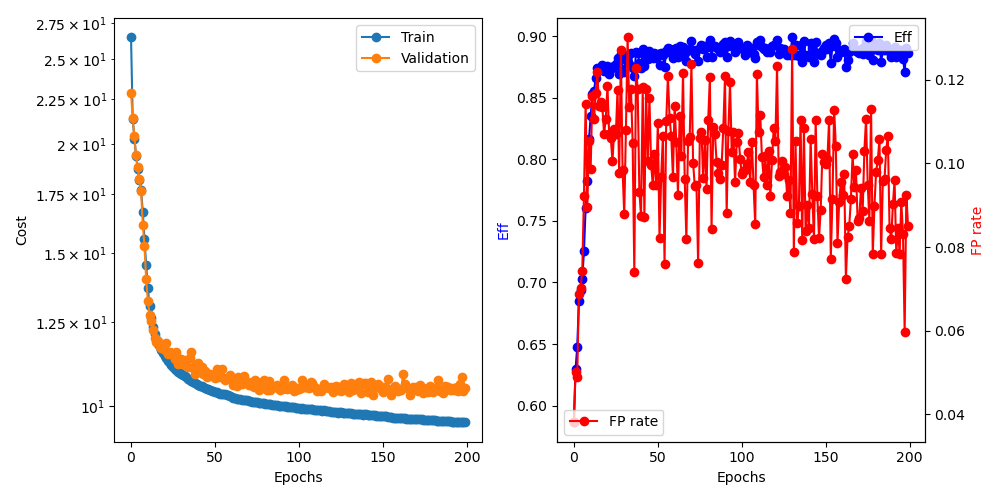

In [12]:
print('for model: ', model)   
run_name = 'SimpleCNN5Layer_Ca G'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))            
            
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    plt.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()